In [2]:
import pandas as pd
import glob
import cv2
from matplotlib import pyplot as plt
def display(img):
    if isinstance(img, str):
        img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
import os



In [5]:
data_dir='/mnt/nas/public2/lilong/data/openimages/character_composition/'

In [11]:
trainimages = glob.glob(data_dir + 'train/target/*.png')
train_controls = [img.replace('target', 'control') for img in trainimages]
train_controls_1 = [img.replace('.png', '_control_1.png') for img in train_controls]
prompt_txt = os.path.join(data_dir, 'train/control/prompt.txt')

In [16]:
trainimages = sorted(trainimages)
train_controls= sorted(train_controls)
train_controls_1 = sorted(train_controls_1)

In [20]:
df = pd.DataFrame.from_dict({'image': trainimages, 'control': train_controls, 'control_1': train_controls_1})

In [22]:
def get_relative_path(x):
    return os.path.relpath(x, data_dir)
df['image'] = df['image'].apply(get_relative_path)
df['control'] = df['control'].apply(get_relative_path)
df['control_1'] = df['control_1'].apply(get_relative_path)

In [24]:
df['prompt'] =  'Add the character to the image'

In [25]:
# save a prompt txt for each image
for i, row in df.iterrows():
    basename = os.path.basename(row['image'])
    basename = basename.replace('.png', '.txt')
    with open(os.path.join(data_dir, 'train/control', basename), 'w') as f:
        f.write(row['prompt'])


In [27]:
df.to_csv(os.path.join(data_dir, 'train.csv'), index=False)

In [13]:
! cat $prompt_txt

Add the character to the image

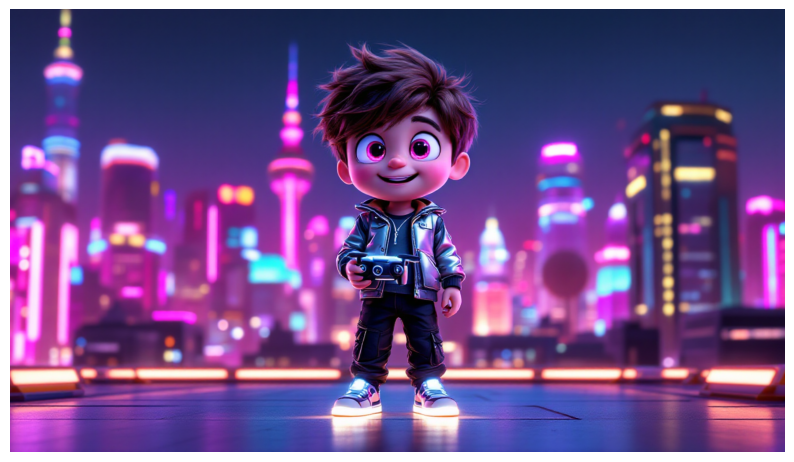

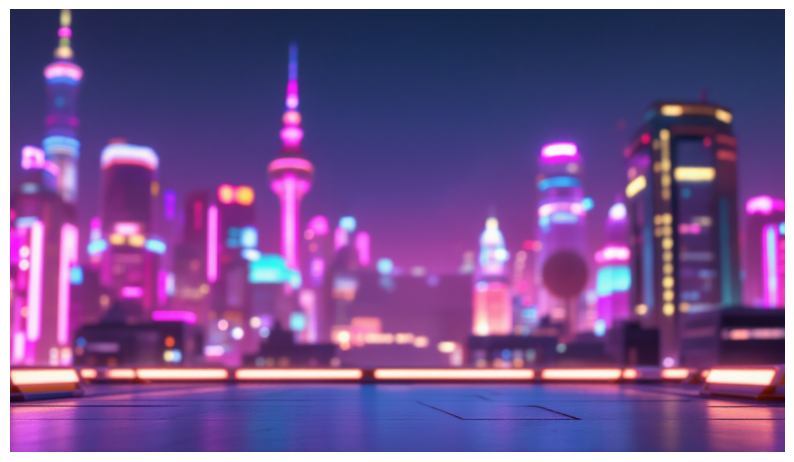

In [6]:
img1 = cv2.imread(os.path.join(data_dir, df.iloc[0]['image']))
img2 = cv2.imread(os.path.join(data_dir, df.iloc[0]['control']))
display(img1)
display(img2)

In [12]:
import cv2
import numpy as np

def make_foreground_mask(
    bg_bgr: np.ndarray,
    fg_bgr: np.ndarray,
    keep_largest: bool = True,
    close_ksize: int = 19,
    open_ksize: int = 5,
    feather_sigma: float = 2.0,
):
    """
    Compute a binary foreground mask from a clean background image and a foreground+background image.

    Args:
        bg_bgr: Background image (H,W,3) in BGR (cv2.imread output).
        fg_bgr: Foreground image (H,W,3) in BGR (same viewpoint as bg_bgr).
        keep_largest: Keep only the largest connected component (typical for single subject).
        close_ksize: Kernel size (odd) for morphological close to fill gaps/holes.
        open_ksize: Kernel size (odd) for morphological open to remove speckles.
        feather_sigma: Gaussian sigma for soft alpha (0 disables).

    Returns:
        mask_bin: uint8 binary mask in {0,255}, same HxW as input.
        alpha_soft: uint8 soft alpha (0..255). If feather_sigma<=0, equal to mask_bin.
    """
    # 0) Resize bg to fg if needed
    if bg_bgr.shape != fg_bgr.shape:
        bg_bgr = cv2.resize(bg_bgr, (fg_bgr.shape[1], fg_bgr.shape[0]), interpolation=cv2.INTER_CUBIC)

    # 1) Light denoise without killing edges
    bg_dn = cv2.bilateralFilter(bg_bgr, d=7, sigmaColor=50, sigmaSpace=7)
    fg_dn = cv2.bilateralFilter(fg_bgr, d=7, sigmaColor=50, sigmaSpace=7)

    # 2) Robust difference in LAB space (emphasize chroma)
    bg_lab = cv2.cvtColor(bg_dn, cv2.COLOR_BGR2LAB).astype(np.float32)
    fg_lab = cv2.cvtColor(fg_dn, cv2.COLOR_BGR2LAB).astype(np.float32)
    diff = np.abs(fg_lab - bg_lab)
    diff_map = 0.6 * (diff[...,1] + diff[...,2]) + 0.4 * diff[...,0]   # chroma-heavy
    diff_norm = cv2.normalize(diff_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # 3) Blur + Otsu threshold
    diff_blur = cv2.GaussianBlur(diff_norm, (9,9), 0)
    _, mask = cv2.threshold(diff_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 4) Morphological cleanup
    open_kernel  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_ksize, open_ksize))
    close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_ksize, close_ksize))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  open_kernel,  iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, close_kernel, iterations=2)

    # 5) Keep largest CC (optional)
    if keep_largest:
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
        if num_labels > 1:
            largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
            mask = np.where(labels == largest, 255, 0).astype(np.uint8)

    # 6) Fill internal holes (border flood-fill trick)
    ff = mask.copy()
    ff_pad = cv2.copyMakeBorder(ff, 1,1,1,1, cv2.BORDER_CONSTANT, value=0)
    cv2.floodFill(ff_pad, None, (0,0), 255)
    holes = cv2.bitwise_not(ff_pad[1:-1,1:-1])
    mask_bin = cv2.bitwise_or(mask, holes)

    # 7) Optional feather for soft edges
    if feather_sigma and feather_sigma > 0:
        alpha_soft = cv2.GaussianBlur(mask_bin, (0,0), sigmaX=feather_sigma, sigmaY=feather_sigma)
    else:
        alpha_soft = mask_bin.copy()

    return mask_bin, alpha_soft


In [25]:
# create mask in control, named as <basename>_mask.png
for i, row in df.iterrows():
    basename = os.path.basename(row['image'])
    basename = basename.replace('.png', '_mask.png')
    img1 = cv2.imread(os.path.join(data_dir, row['image']))
    img2 = cv2.imread(os.path.join(data_dir, row['control']))
    mask_bin, alpha_soft = make_foreground_mask(img1, img2)
    cv2.imwrite(os.path.join(data_dir, 'train/control', basename), mask_bin)

In [13]:
mask_bin, alpha_soft = make_foreground_mask(
    img1, img2,
    keep_largest = True,
    close_ksize = 19,
    open_ksize = 5,
    feather_sigma = 2.0,
)

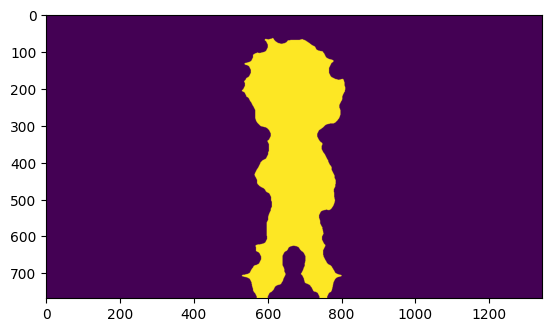

In [14]:
plt.imshow(mask_bin)

In [19]:
(alpha_soft==2).sum()

np.int64(785)

In [24]:
(mask_bin==254).sum()

np.int64(0)

In [4]:
df = pd.read_csv(os.path.join(data_dir, 'train.csv'))

In [7]:
import numpy as np
mask = np.abs(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) - cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY))

In [8]:
# mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

In [9]:
mask.shape

(768, 1344)

In [10]:
mask = mask< 100

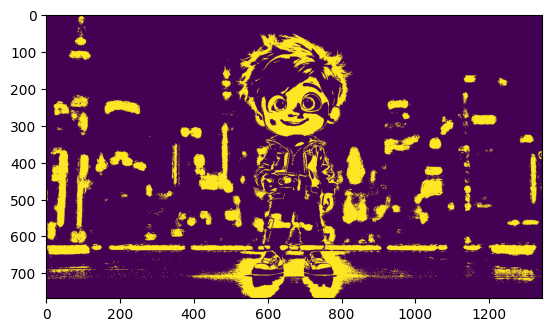

In [11]:
plt.imshow(mask)

In [50]:
mask

array([[251, 252, 252, ..., 250, 251, 250],
       [251, 251, 252, ..., 251, 250, 249],
       [251, 252, 252, ..., 251, 251, 250],
       ...,
       [248, 248, 249, ..., 250, 250, 250],
       [249, 248, 249, ..., 250, 249, 250],
       [249, 248, 248, ..., 250, 250, 249]],
      shape=(768, 1344), dtype=uint8)

In [28]:
def get_relative_path(x):
    return os.path.relpath(x, data_dir)

In [35]:
# create test csv
test_controls_1 = glob.glob(data_dir + 'test/control/*_control_1.*')
test_controls = [img.replace('_control_1.', '.') for img in test_controls_1]
test_controls_1 = sorted(test_controls_1)
test_controls = sorted(test_controls)
df_test = pd.DataFrame.from_dict({'control': test_controls, 'control_1': test_controls_1})
df_test['control'] = df_test['control'].apply(get_relative_path)
df_test['control_1'] = df_test['control_1'].apply(get_relative_path)

In [36]:
df_test

,control,control_1
0,test/control/forest_boy.webp,test/control/forest_boy_control_1.webp
1,test/control/forest_dog.webp,test/control/forest_dog_control_1.webp
2,test/control/forest_girl.webp,test/control/forest_girl_control_1.webp
3,test/control/forest_honey_small.png,test/control/forest_honey_small_control_1.png
4,test/control/living_room_boy.webp,test/control/living_room_boy_control_1.webp
5,test/control/living_room_dog.webp,test/control/living_room_dog_control_1.webp
6,test/control/living_room_girl.webp,test/control/living_room_girl_control_1.webp
7,test/control/living_room_honey_small.png,test/control/living_room_honey_small_control_1...
8,test/control/scene_boy.webp,test/control/scene_boy_control_1.webp
9,test/control/scene_dog.webp,test/control/scene_dog_control_1.webp


In [48]:
df_test['prompt'] = 'Add the character to the image'
df_test
# create rpompt txt for train images

,control,control_1,prompt
0,test/control/forest_boy.webp,test/control/forest_boy_control_1.webp,Add the character to the image
1,test/control/forest_dog.webp,test/control/forest_dog_control_1.webp,Add the character to the image
2,test/control/forest_girl.webp,test/control/forest_girl_control_1.webp,Add the character to the image
3,test/control/forest_honey_small.png,test/control/forest_honey_small_control_1.png,Add the character to the image
4,test/control/living_room_boy.webp,test/control/living_room_boy_control_1.webp,Add the character to the image
5,test/control/living_room_dog.webp,test/control/living_room_dog_control_1.webp,Add the character to the image
6,test/control/living_room_girl.webp,test/control/living_room_girl_control_1.webp,Add the character to the image
7,test/control/living_room_honey_small.png,test/control/living_room_honey_small_control_1...,Add the character to the image
8,test/control/scene_boy.webp,test/control/scene_boy_control_1.webp,Add the character to the image
9,test/control/scene_dog.webp,test/control/scene_dog_control_1.webp,Add the character to the image


In [49]:
# create rpompt txt for train images
for i, row in df_test.iterrows():
    basename = row['control']
    basename = ".".join(basename.split(".")[:-1])
    basename = basename + ".txt"
    print(basename)
    with open(os.path.join(data_dir, basename), 'w') as f:
        f.write(row['prompt'])


test/control/forest_boy.txt
test/control/forest_dog.txt
test/control/forest_girl.txt
test/control/forest_honey_small.txt
test/control/living_room_boy.txt
test/control/living_room_dog.txt
test/control/living_room_girl.txt
test/control/living_room_honey_small.txt
test/control/scene_boy.txt
test/control/scene_dog.txt
test/control/scene_girl.txt
test/control/scene_honey_small.txt


In [39]:
basename

'filtered_035.txt'

In [51]:
df_test.to_csv(os.path.join(data_dir, 'test.csv'), index=False)